In [103]:
### Import functions from modules
%reload_ext autoreload
%autoreload 2
from pretreatment_methods import *
from w2v_feats_adding import *

In [2]:
pre_local="/home/jlevyabi/seacabo/fempl_big_sim/sent_class/twitter-datasets/"
pre_remote="/datastore/complexnet/jlevyabi/network_representation/data_files/w2v_files/word2vec_twitter_model/"
train_data=TwitterSentimentData(loc_data=pre_local,pre_cleaned=False,is_test_file=False)
test_data=TwitterSentimentData(loc_data=pre_local,pre_cleaned=False,is_test_file=True)

In [3]:
# Clean Data
complete_data=TwitterAddTextData(train_data,1,1,1,1,1,1,1)
complete_data.add_text_features()
cleaned=TwitterDataCleaning(complete_data)
sentiment_data=SentimentAnalysis(cleaned)

In [4]:
# Analysis Data
sentiment_data.polar_df_3grams[(sentiment_data.polar_df_3grams.polarity<0.1)
                               & (sentiment_data.polar_df_3grams.total>100 )].sample(10)

,3gram,pos_sent,neg_sent,total,polarity
750885,"(top, news, -)",0,104,104,0.0
764844,"("", length, ()",0,171,171,0.0
742983,"(wide, complete, black)",0,356,356,0.0
753959,"(), (, kindle)",0,163,163,0.0
753552,"(wide, complete, brown)",0,161,161,0.0
761852,"(frame, is, manufacture)",0,115,115,0.0
760089,"((, press, release)",0,132,132,0.0
743881,"(a-tech, brand, mb)",0,217,217,0.0
744347,"(laptop, battery, mah)",0,161,161,0.0
1195125,"(:, m, ago)",0,129,129,0.0


In [5]:
full_data=Tweets_w2v_Features(pre_filled_feats=cleaned.info,built_w2v=pre_remote+"word2vec_twitter_model.bin")

2017-12-14 18:43:41,141 : INFO : loading projection weights from /datastore/complexnet/jlevyabi/network_representation/data_files/w2v_files/word2vec_twitter_model/word2vec_twitter_model.bin
2017-12-14 18:44:41,043 : INFO : loaded (3039345, 400) matrix from /datastore/complexnet/jlevyabi/network_representation/data_files/w2v_files/word2vec_twitter_model/word2vec_twitter_model.bin


In [6]:
full_data.sp_features(min_times=1)

  0%|          | 0/35946 [00:00<?, ?it/s]

Nb words in vocabulary.... 38365
Computing similarity matrix .....


100%|██████████| 35946/35946 [00:00<00:00, 129011.78it/s]


Spectral Clustering ....
SC labeling .... 


In [7]:
full_data.nlm_features()

In [8]:
def get_embedding(embed_name,df):
    dim_total=len((df.head(1)[embed_name][0]))
    return np.array(np.vstack([sample[0]
                      for it,sample in (df[[embed_name]].iterrows())]))

In [9]:
w2v_fts=get_embedding("w2v",full_data.info.data[full_data.info.data['w2v'].isnull()== False])
cfd_fts=get_embedding("cfd",full_data.info.data[full_data.info.data['w2v'].isnull()== False])
shallow=["number_of_uppercases","number_of_exclamations","number_of_questions","number_of_sights",
         "number_of_hashtags","number_of_mentions","number_of_urls"]
shallow_fts=full_data.info.data[full_data.info.data['w2v'].isnull()== False][shallow]

In [10]:
target=full_data.info.data[full_data.info.data['w2v'].isnull()== False]["pos_sent"]
fts=np.hstack([w2v_fts,cfd_fts,shallow_fts])

In [15]:
all_but_text=full_data.info.data.drop("text",axis=1)
import pickle
pickle.dump(all_but_text,open("/home/jlevyabi/seacabo/fempl_big_sim/sent_class/checkpt_data/dic_all.p","wb"))

#all_but_text=pickle.load(open("/home/jlevyabi/seacabo/fempl_big_sim/sent_class/checkpt_data/dic_all.p","rb"))

w2v_fts=get_embedding("w2v",all_but_text[all_but_text['w2v'].isnull()== False])
cfd_fts=get_embedding("cfd",all_but_text[all_but_text['w2v'].isnull()== False])
shallow=["number_of_uppercases","number_of_exclamations","number_of_questions","number_of_sights",
         "number_of_hashtags","number_of_mentions","number_of_urls"]
shallow_fts=all_but_text[all_but_text['w2v'].isnull()== False][shallow]

target=all_but_text[all_but_text['w2v'].isnull()== False]["pos_sent"]
fts=np.hstack([w2v_fts,cfd_fts,shallow_fts])

In [41]:
from sklearn.model_selection import KFold, train_test_split
target_two_cols=np.transpose(np.vstack([target,target]))
target_two_cols[target_two_cols[:,0]==-1,0]=0
target_two_cols[target_two_cols[:,1]==1,1]=0
target_two_cols=np.abs(target_two_cols)
X_train, X_test, y_train, y_test=train_test_split(fts,target_two_cols)

In [18]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e4,verbose=5)
logreg.fit(X_train, y_train)
pred=logreg.predict(X_test)print(classification_report(y_test, pred))

             precision    recall  f1-score   support

         -1       0.83      0.79      0.81     24738
          1       0.80      0.83      0.82     24497

avg / total       0.81      0.81      0.81     49235



## Deep Neural Network: Simple

In [ ]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Nadam, Adagrad, Adadelta, Adam, Adamax

def build_model(input_dim, nb_class):
    units=[input_dim//2,input_dim//4,input_dim//4,input_dim//10,input_dim//50]
    model = Sequential()
    model.add(Dense(input_dim=input_dim, units=units[0], activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(input_dim=units[0], units=units[1], activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(input_dim=units[1], units=units[2], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(input_dim=units[2], units=units[3], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(input_dim=units[3], units=units[4], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim=nb_class, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adadelta')
    return model

checkpointer = ModelCheckpoint(filepath='/home/jlevyabi/seacabo/fempl_big_sim/sent_class/checkpt_data/weights.hdf5',
                               verbose=1, save_best_only=True)
tf_model=build_model(input_dim=X_train.shape[1],nb_class=2)
tf_model.fit(X_train, y_train, batch_size=1000, epochs=1000, verbose=2)
score = tf_model.evaluate(X_test, y_test, batch_size=1000)

preds=tf_model.predict(X_test)
predis=np.int64(preds>0.5)
print(classification_report(y_test[:,0],predis[:,0]))
             precision    recall  f1-score   support

          0       0.85      0.83      0.84     24800
          1       0.83      0.85      0.84     24435

avg / total       0.84      0.84      0.84     49235

## Deep Convolutional Neural Network

In [112]:
full_data.info.data[["text","pos_sent"]].to_csv(
    "/home/jlevyabi/seacabo/fempl_big_sim/sent_class/checkpt_data/txt_and_trgt.csv",sep="\t")

In [ ]:
from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding,Dropout
from keras.layers import Flatten
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import gensim


model = gensim.models.KeyedVectors.load_word2vec_format("/datastore/complexnet/jlevyabi/network_representation/data_files/w2v_files/word2vec_twitter_model/word2vec_twitter_model.bin",
binary=True,unicode_errors='ignore')

MAX_SEQUENCE_LENGTH=140
MAX_NB_WORDS=70000
VALIDATION_SPLIT=0.2
EMBEDDING_DIM=model.vector_size

data_full=pd.read_csv("/home/jlevyabi/seacabo/fempl_big_sim/sent_class/checkpt_data/txt_and_trgt.csv",sep="\t")
data_full=data_full.drop("Unnamed: 0",axis=1)
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)

data_full=data_full[[len(x)<MAX_SEQUENCE_LENGTH for x in data_full.text]]
tokenizer.fit_on_texts(data_full.text)
sequences = tokenizer.texts_to_sequences(data_full.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(data_full.pos_sent))
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

embeddings_index={w:model[w] for w in tokenizer.word_docs.keys() if w in model}
num_words = len(embeddings_index)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

nb_classes=2
embedding_layer = Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
dropout1 = Dropout(0.8)
dropout2 = Dropout(0.6)
dropout3 = Dropout(0.5)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = dropout1(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Flatten()(x)
x = dropout2(x)
x = Dense(128, activation='relu')(x)
x = dropout3(x)
preds = Dense(nb_classes, activation='softmax')(x)
model = Model(sequence_input, preds)
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])        
    
from sklearn.model_selection import StratifiedKFold
cvscores = []
kfold=3
for k in tqdm(range(kfold)):
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['acc'])    
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    x_train = data[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = data[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]
    out=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=2, batch_size=128)
    cvscores.append(out.history['val_acc'][0])

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores),np.std(cvscores)))

##  TSNE Visualization

In [ ]:
all_but_text=pickle.load(open("/home/jlevyabi/seacabo/fempl_big_sim/sent_class/checkpt_data/dic_all.p","rb"))
def get_embedding(embed_name,df):
    dim_total=len((df.head(1)[embed_name][0]))
    return np.array(np.vstack([sample[0]
                      for it,sample in tqdm(df[[embed_name]].iterrows())]))

os.system("cd ~/seacabo/python_scripts/Librairies/Multicore-TSNE/")
relevant_samples=all_but_text[all_but_text['w2v'].isnull()==False]
shallow=["number_of_uppercases","number_of_exclamations","number_of_questions","number_of_sights",
         "number_of_hashtags","number_of_mentions","number_of_urls"]

w2v_fts=get_embedding("w2v",relevant_samples)
cfd_fts=get_embedding("cfd",relevant_samples)
shallow_fts=relevant_samples[shallow]
targets=relevant_samples["pos_sent"]

print("TSNE: Word2ve3c features")
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=60)
w2v_target = tsne.fit_transform(w2v_fts)
del tsne
print("TSNE: Topic features")
tsne = TSNE(n_jobs=60)
cdf_target = tsne.fit_transform(cfd_fts)
del tsne
print("TSNE: Shallow features")
tsne = TSNE(n_jobs=60)
shallow_target = tsne.fit_transform(shallow_fts)

dic_tsne={"w2v_target":w2v_target,"cdf_target":cdf_target,"shallow_target":shallow_target,"sent_target":targets}
pickle.dump(dic_tsne, open( "/home/jlevyabi/seacabo/fempl_big_sim/sent_class/checkpt_data/dic_tsne.p", "wb" ))

In [113]:
import pickle
dic_tsne=pickle.load(open("/home/jlevyabi/seacabo/fempl_big_sim/sent_class/checkpt_data/dic_tsne_full.p","rb"))
fts_target=dic_tsne["fts_target"]
targets=dic_tsne["sent_target"]

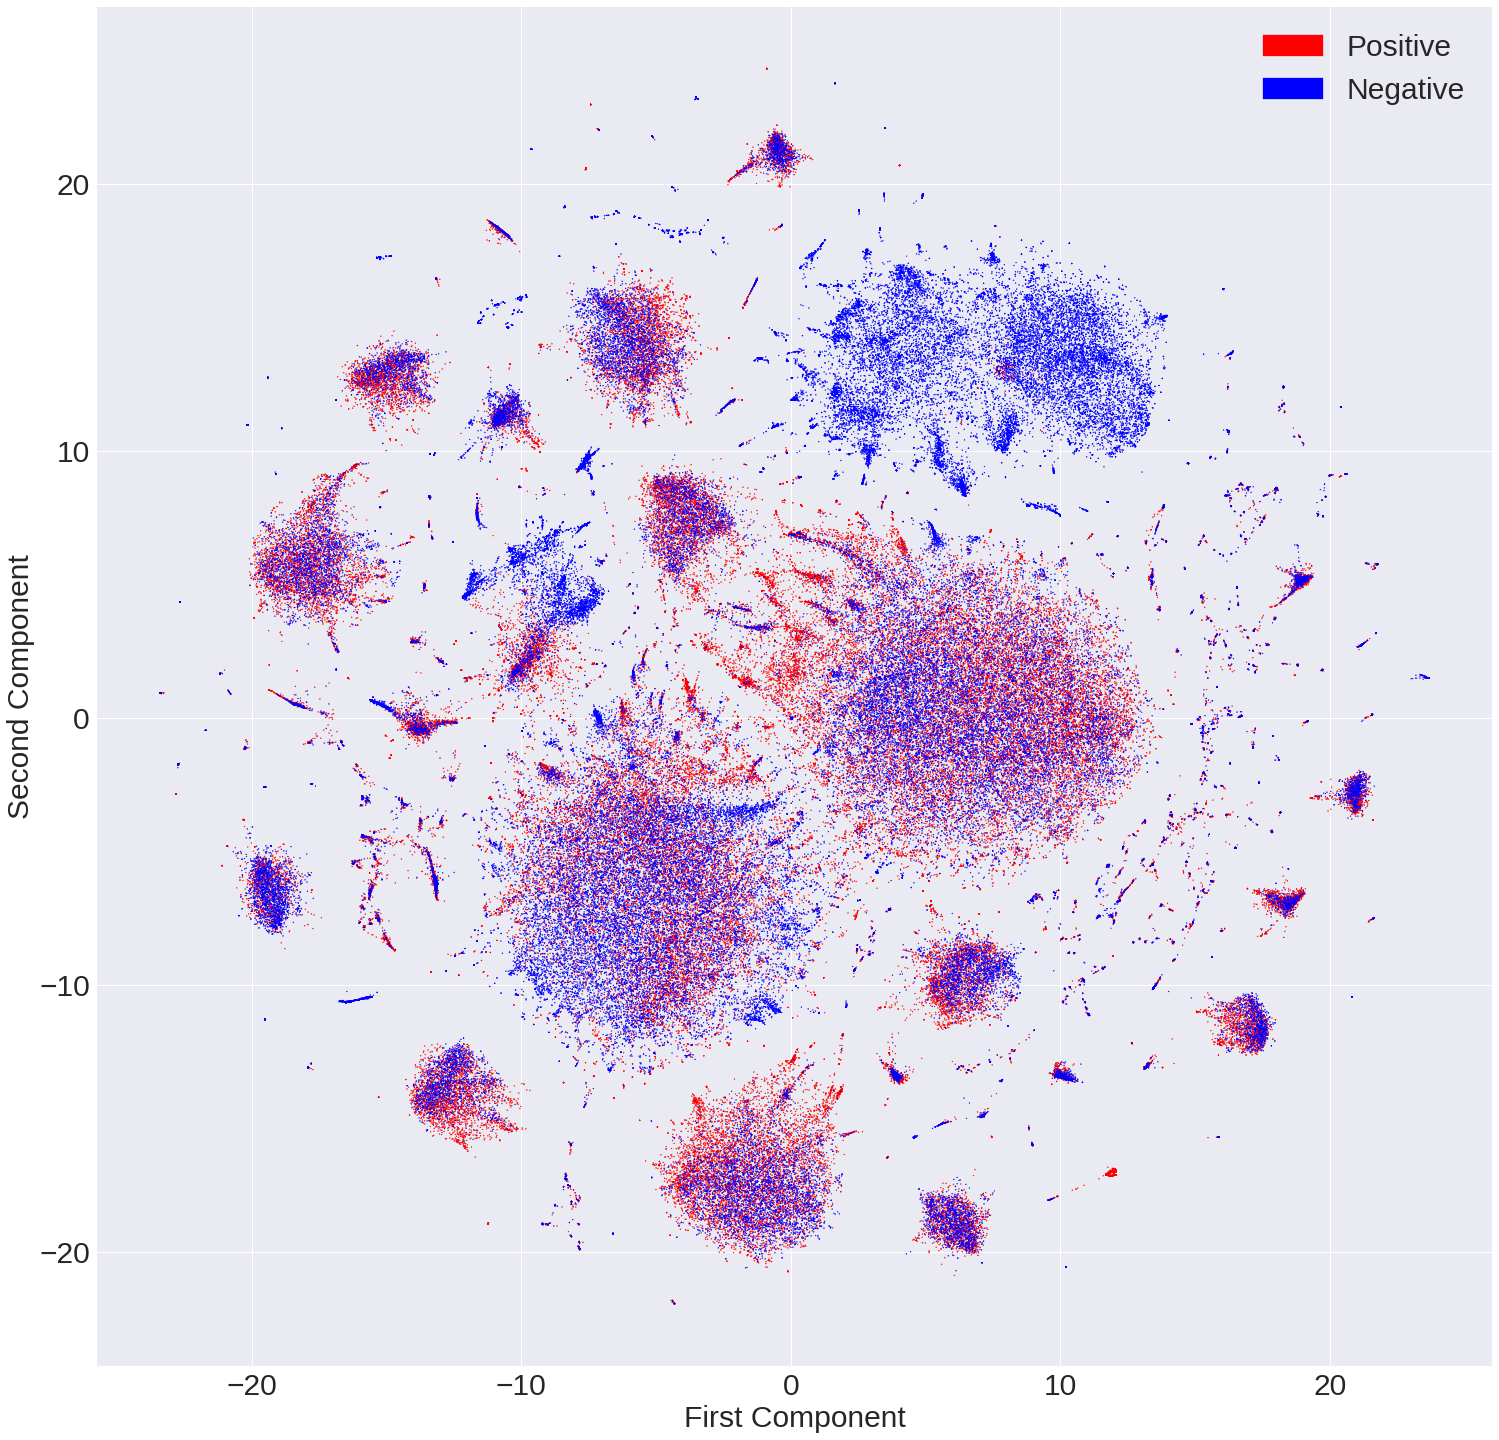

In [116]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches


f=plt.figure(figsize=(25,25))
col_target=targets.copy()
col_target[col_target==1]="red"
col_target[col_target==-1]="blue"
s=30
plt.scatter(x=fts_target[:,0],y=fts_target[:,1],c=col_target,s=1)
plt.plot([0],[0],'.',c="red",label="Positive")
plt.plot([0],[0],'.',c="blue", label="Negative")
plt.xlabel("First Component", size=s)
plt.ylabel("Second Component", size=s)
plt.xticks(fontsize=s)
plt.yticks(fontsize=s)
red_patch = mpatches.Patch(color='red', label='Positive')
blue_patch = mpatches.Patch(color='blue', label='Negative')
                            
legend=plt.legend(handles=[red_patch,blue_patch],prop={'size':s})

plt.show()